In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataset as dataset
import numpy as np

from dataset import TestDataset
from model import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# Load trained model
net = initialize_model2()
n_features = 512
tgt = 0

# Replace predictor
net.classifier = nn.Sequential(
        nn.Linear(n_features, 50),
        nn.Sigmoid(),
        nn.Linear(50, 20),
        nn.Sigmoid(),
        nn.Linear(20, 1)
    )

SAVED_MODEL_PATH = 'checkpoints/vgg11bn_2_e2e'
net.load_state_dict(torch.load(SAVED_MODEL_PATH))
net

VGG(
  (features): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [16]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.
    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Targets for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    # Make input tensor require gradient
    X.requires_grad_()
    saliency = None
    criterion = nn.BCEWithLogitsLoss()
    ##############################################################################
    # Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect #
    # to each input image. You first want to compute the loss over the correct #
    # scores (we'll combine losses across a batch by summing), and then compute #
    # the gradients with a backward pass. #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    scores = model(X).squeeze()
    loss = criterion(scores, y)
    loss.backward()
    saliency, _ = torch.max(torch.abs(X.grad), dim=1)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    # END OF YOUR CODE #
    ##############################################################################
    return saliency

In [17]:
# Get dataset
DATA_FILE = 'E:/xplore_data/data/images.h5'
HEALTH_FILE = 'data/dhs_gps.csv'
dimages = TestDataset(DATA_FILE, HEALTH_FILE)
dimagesloader = torch.utils.data.DataLoader(dimages, batch_size=4, shuffle=False, num_workers=0)

In [76]:
X_raw, _, stats = next(iter(dimagesloader))
print(X.shape)
y = stats[:, 14+tgt]
c_id = stats[:, 0]
print(y.shape)

torch.Size([4, 9, 333, 333])
torch.Size([4])


In [77]:
saliency = compute_saliency_maps(X_raw, y, net)
saliency.shape

torch.Size([4, 333, 333])

In [165]:
def prepare(X_raw):
    #Un-normalize X and prepare it for plotting
    means = torch.Tensor([10.1707, 14.8429, 25.7929, 
                          30.0618, 73.5301, 69.8245, 
                          48.3126, 69.7498, 62.0024])
    stds = torch.Tensor([6.0652,  7.4589, 10.7411, 
                         18.1305, 17.0735, 29.9055, 
                         28.0655,  8.7038, 8.7830])
    # Get X to the range 0-1
    X = X_raw.detach()
    X = X * stds[None, :, None, None] + means[None, :, None, None]
    X /= 256
#     print(X.max(2)[0].max(2)[0])
    vis_bands = [3, 2, 1]
    ir_bands = [6, 4, 0]
    X[:, vis_bands, :, :] /= torch.Tensor([0.25, 0.2, 0.2])[None, :, None, None]
    X[:, ir_bands, :, :] /= torch.Tensor([0.3, 0.5, 0.1])[None, :, None, None]
    X = torch.clamp(X, 0, 1)
    return X
#     print(X.max(2)[0].max(2)[0])

In [183]:
import matplotlib.pyplot as plt
def show_saliency_maps(X_raw, saliency):
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    X = prepare(X_raw)
    saliency = saliency.numpy()#[:, :, :, None]
    saliency = saliency**2
    N = X.shape[0]
    
    vis = X[:, vis_bands].permute((0, 2, 3, 1))
    ir = X[:, ir_bands].permute((0, 2, 3, 1))
    
    f, axs = plt.subplots(N,3,figsize=(15,20))
    f.subplots_adjust(wspace=0, hspace=0.1)
    axs[0,0].set_title('RGB Bands')
    axs[0,1].set_title('IR Bands')
    axs[0,2].set_title('Saliency')
    for i in range(4):
        axs[i,0].imshow(vis[i])
        axs[i,0].axis('off')
        axs[i,1].imshow(ir[i])
        axs[i,1].axis('off')
        axs[i,2].imshow(saliency[i], cmap='hot')
        axs[i,2].axis('off')

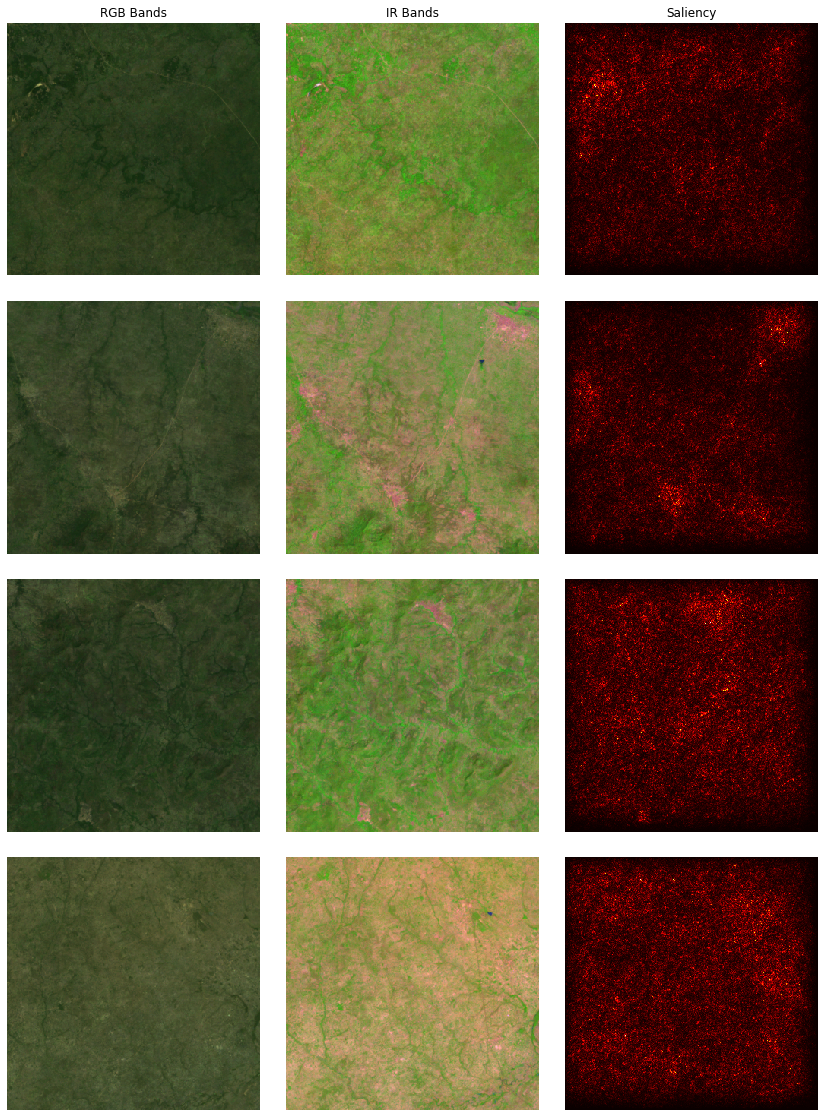

In [184]:
show_saliency_maps(X_raw, saliency)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019B418ACD08>,
      dtype=object)